## Imports

In [ ]:
!pip install tensorflow keras kagglehub numpy pandas optuna joblib scikit-learn matplotlib seaborn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, chi2
import os
from sklearn.metrics import mean_absolute_percentage_error
import kagglehub
import pickle
import joblib





/Users/maltestaab/.pyenv/versions/3.8.12/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

## Loading the dataset

In [2]:
# Download dataset
path = kagglehub.dataset_download("sidharth178/car-prices-dataset")

# List available files
files = os.listdir(path)
print("Available files:", files)

# Load both datasets into DataFrames
df = pd.read_csv(os.path.join(path, "train.csv"))
df_test = pd.read_csv(os.path.join(path, "test.csv"))

# Display first few rows
print("Train Dataset:")
print(df.head())

print("\nTest Dataset:")
print(df_test.head())

Available files: ['test.csv', 'train.csv']
Train Dataset:
         ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic     

In [3]:
# To make all letters into lowercase for JSON file formatting later on
# Function to convert only strings to lowercase
def lowercase_text(cell):
    if isinstance(cell, str):  # Check if cell is a string
        return cell.lower()  # Convert only text to lowercase
    return cell  # Leave numbers unchanged

# Apply the function to the entire DataFrame
df = df.applymap(lowercase_text)

In [4]:
# Define the mapping of old column names to new column names
column_mapping = {
    'Manufacturer': 'manufacturer',
    'Model': 'model',
    'Prod. year': 'prod_year',
    'Category': 'category',
    'Leather interior': 'leather_interior',
    'Fuel type': 'fuel_type',
    'Engine volume': 'engine_volume',
    'Mileage': 'mileage',
    'Cylinders': 'cylinders',
    'Gear box type': 'gear_box_type',
    'Drive wheels': 'drive_wheels',
    'Doors': 'doors',
    'Wheel': 'wheel',
    'Color': 'color',
    'Airbags': 'airbags'
}

# Rename columns based on the mapping
df.rename(columns=column_mapping, inplace=True)

# Print updated column names
print(df.columns)


Index(['ID', 'Price', 'Levy', 'manufacturer', 'model', 'prod_year', 'category',
       'leather_interior', 'fuel_type', 'engine_volume', 'mileage',
       'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color',
       'airbags'],
      dtype='object')


## Preprocessing (Checking NaN)

In [5]:
print(df.isnull().sum())  # Shows missing values per column

ID                  0
Price               0
Levy                0
manufacturer        0
model               0
prod_year           0
category            0
leather_interior    0
fuel_type           0
engine_volume       0
mileage             0
cylinders           0
gear_box_type       0
drive_wheels        0
doors               0
wheel               0
color               0
airbags             0
dtype: int64


In [6]:
print(df.isnull().values.any())  # Returns True if any NaN values exist

False


## Handling Categorical Variables

The ID and Mileage features

In [7]:
df = df.drop("ID", axis=1)  # axis=1 means dropping a column

# Remove "km" and convert to numeric
df["mileage"] = df["mileage"].str.replace(" km", "", regex=False).astype(int)

In [8]:
df = df.drop("Levy", axis=1)
# Display updated DataFrame
print(df.head())
print(df.dtypes)  # Check if it's now integer

   Price manufacturer    model  prod_year   category leather_interior  \
0  13328        lexus   rx 450       2010       jeep              yes   
1  16621    chevrolet  equinox       2011       jeep               no   
2   8467        honda      fit       2006  hatchback               no   
3   3607         ford   escape       2011       jeep              yes   
4  11726        honda      fit       2014  hatchback              yes   

  fuel_type engine_volume  mileage  cylinders gear_box_type drive_wheels  \
0    hybrid           3.5   186005        6.0     automatic          4x4   
1    petrol             3   192000        6.0     tiptronic          4x4   
2    petrol           1.3   200000        4.0      variator        front   
3    hybrid           2.5   168966        4.0     automatic          4x4   
4    petrol           1.3    91901        4.0     automatic        front   

    doors             wheel   color  airbags  
0  04-may        left wheel  silver       12  
1  04-may 

Identifying remaining troublesome features

In [9]:
print(df.describe(include="all"))

               Price manufacturer  model     prod_year category  \
count   1.923700e+04        19237  19237  19237.000000    19237   
unique           NaN           65   1511           NaN       11   
top              NaN      hyundai  prius           NaN    sedan   
freq             NaN         3769   1083           NaN     8736   
mean    1.855593e+04          NaN    NaN   2010.912824      NaN   
std     1.905813e+05          NaN    NaN      5.668673      NaN   
min     1.000000e+00          NaN    NaN   1939.000000      NaN   
25%     5.331000e+03          NaN    NaN   2009.000000      NaN   
50%     1.317200e+04          NaN    NaN   2012.000000      NaN   
75%     2.207500e+04          NaN    NaN   2015.000000      NaN   
max     2.630750e+07          NaN    NaN   2020.000000      NaN   

       leather_interior fuel_type engine_volume       mileage     cylinders  \
count             19237     19237         19237  1.923700e+04  19237.000000   
unique                2         7    

Handling the Model Feature

In [10]:
df["model_frequency"] = df["model"].map(df["model"].value_counts())

In [11]:
# Get model frequency sorted from largest to smallest
model_counts = df["model"].value_counts().reset_index()
model_counts.columns = ["model", "count"]

# Calculate cumulative percentage
model_counts["cumulative_Percentage"] = model_counts["count"].cumsum() / model_counts["count"].sum()

print(model_counts.head(10))  # Show top 10 most frequent models

      model  count  cumulative_Percentage
0     prius   1083               0.056298
1    sonata   1079               0.112388
2     camry    938               0.161148
3   elantra    922               0.209076
4     e 350    542               0.237251
5  santa fe    533               0.264958
6       fit    446               0.288143
7        h1    437               0.310859
8    tucson    429               0.333160
9        x5    353               0.351510


In [12]:
# Get models contributing to 50% of total frequency
top_50_models = model_counts[model_counts["cumulative_Percentage"] <= 0.50]["model"].tolist()

print("Top 50% Models:", top_50_models)  # Show first 10 models

Top 50% Models: ['prius', 'sonata', 'camry', 'elantra', 'e 350', 'santa fe', 'fit', 'h1', 'tucson', 'x5', 'aqua', 'cruze', 'fusion', 'optima', 'gx 460', 'transit', 'highlander', 'ml 350', 'jetta', 'actyon', 'civic', 'rexton']


In [13]:
# Replace less frequent models with "Others"
df["Model_Grouped"] = df["model"].apply(lambda x: x if x in top_50_models else "others")

print(df["Model_Grouped"].value_counts())  # Check distribution

Model_Grouped
others        9698
prius         1083
sonata        1079
camry          938
elantra        922
e 350          542
santa fe       533
fit            446
h1             437
tucson         429
x5             353
aqua           331
cruze          302
fusion         301
optima         233
gx 460         224
transit        217
highlander     216
ml 350         202
jetta          201
actyon         188
civic          187
rexton         175
Name: count, dtype: int64


In [14]:
df = pd.get_dummies(df, columns=["Model_Grouped"], drop_first=True)
df = df.drop("model", axis=1)
df = df.drop("model_frequency", axis=1)

Transforming Engine and Cylinders into a Continuous Feature

In [15]:
# Step 1: Create the binary 'Turbo' column
df['turbo'] = df['engine_volume'].str.contains('Turbo', case=False, regex=False).astype(int)

# Step 2: Remove 'Turbo' from the original 'engine' column
df['engine_volume'] = df['engine_volume'].str.replace(' Turbo', '', case=False, regex=False).str.strip()

# Extract only the numeric part before any text
df["engine_volume"] = df["engine_volume"].str.extract(r"(\d+\.?\d*)")[0].astype(float) * 1000  # Convert to cubic cm

# Convert to integer
df["engine_volume"] = df["engine_volume"].astype(int)

# Convert to integer
df["cylinders"] = df["cylinders"].astype(int)

Creating Dummy Variables for the Remaining Categorical Features

In [16]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=["object"]).columns
print("Categorical Columns:", categorical_cols)

Categorical Columns: Index(['manufacturer', 'category', 'leather_interior', 'fuel_type',
       'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color'],
      dtype='object')


In [17]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## Feature Selection

### Correlation Matrix

In [18]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Set correlation threshold
threshold = 0.7  # Change to 0.8 if needed

# Find highly correlated feature pairs
high_corr_features = [(col1, col2, corr_matrix.loc[col1, col2])
                      for col1 in corr_matrix.columns
                      for col2 in corr_matrix.columns
                      if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > threshold]

# Convert to DataFrame for better readability
high_corr_df = pd.DataFrame(high_corr_features, columns=["Feature 1", "Feature 2", "Correlation"])

print(high_corr_df)

              Feature 1             Feature 2  Correlation
0         engine_volume             cylinders     0.778524
1             cylinders         engine_volume     0.778524
2  Model_Grouped_optima      manufacturer_kia     0.740249
3      manufacturer_kia  Model_Grouped_optima     0.740249


### Random Forest Feature Selection

In [19]:
Y = df["Price"]
X = df.drop("Price", axis=1)

# Find the 99.9th percentile (top 0.1% cutoff)
percentile_99 = np.percentile(Y, 99.9)

# Remove the top 0.1% of highest values
mask = Y <= percentile_99
Y = Y[mask]
X = X.loc[mask]  # Keep only corresponding X values

#print(f"Training Size: {len(Y)}")
print(f"99.9th Percentile Cutoff Value: {percentile_99}")

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
model.fit(X, Y) #For the feature selection, we can use the whole dataset, dont need train-test split

# Get feature importance scores
importance = model.feature_importances_

# Convert to DataFrame
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": importance})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

99.9th Percentile Cutoff Value: 171375.6200000134


In [20]:
# Calculate cumulative importance
feature_importance["Cumulative Importance"] = feature_importance["Importance"].cumsum()

# Select features contributing to top 98% importance
threshold = 0.98
selected_features = feature_importance[feature_importance["Cumulative Importance"] <= threshold]["Feature"]
X_new = X[selected_features].copy()

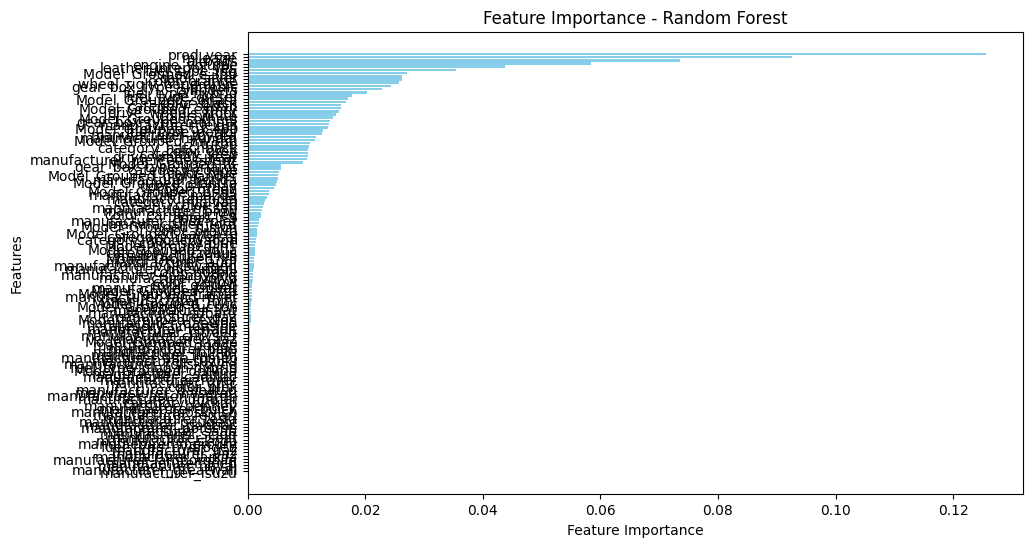

In [21]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance - Random Forest")
plt.gca().invert_yaxis()  # Reverse order to show most important features on top
plt.show()

## Splitting into Training, Validation and Test set

In [22]:
# First, split into Training (80%) and Temp (20%) (Test + Validation)
X_train, X_temp, y_train, y_temp = train_test_split(X_new, Y, test_size=0.2, random_state=42)

# Then, split Temp (20%) into Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print sizes
print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")
print(f"Test Set: {X_test.shape}")

Training Set: (15373, 66)
Validation Set: (1922, 66)
Test Set: (1922, 66)


## Scaling the Data

In [23]:
# Scale the features (Neural networks perform better with normalized data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Checking Target Variable

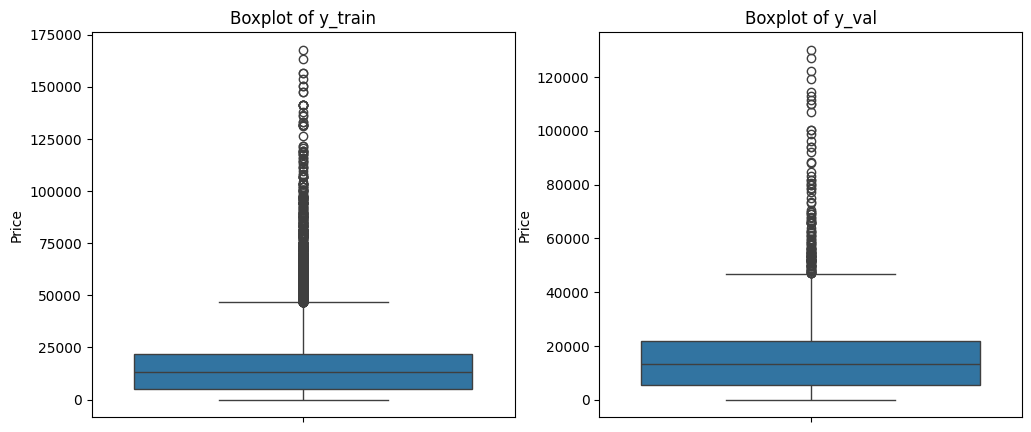

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Boxplot for y_train
plt.subplot(1, 2, 1)
sns.boxplot(y=y_train)
plt.title("Boxplot of y_train")

# Boxplot for y_val
plt.subplot(1, 2, 2)
sns.boxplot(y=y_val)
plt.title("Boxplot of y_val")

plt.show()

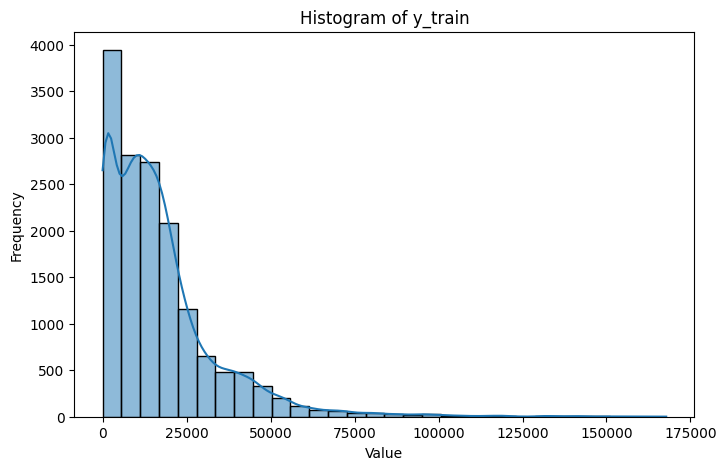

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram for y_train
plt.figure(figsize=(8,5))
sns.histplot(y_train, bins=30, kde=True)
plt.title("Histogram of y_train")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

There are extreme outliers and the target variable is heavily skewed. Therefore we log-transform y_train and y_val

In [26]:
import numpy as np

y_train = np.log1p(y_train)  # log(1 + y) to avoid log(0)

In [27]:
y_val_log = np.log1p(y_val)

# Models

## Baseline Model / Linear Regression

In [28]:
# Initialize Linear Regression model
baseline = LinearRegression()

# Train on training data
baseline.fit(X_train_scaled, y_train)

# Make predictions on validation set
y_pred_baseline = baseline.predict(X_val_scaled)

In [29]:
# Compute Evaluation Metrics
mae = mean_absolute_error(y_val, y_pred_baseline)
mse = mean_squared_error(y_val, y_pred_baseline)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_baseline)

# Print Results
print(f"Baseline Linear Regression Performance:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Baseline Linear Regression Performance:
MAE  (Mean Absolute Error): 17139.3593
MSE  (Mean Squared Error): 595781060.8433
RMSE (Root Mean Squared Error): 24408.6268
R² Score: -0.9725


## Baseline 2: Predicting using the mean

In [30]:
# Compute mean of y_train
baseline_mean = np.mean(y_train)

# Make predictions (same mean for every data point in validation set)
y_pred_baseline_mean = np.full_like(y_val, baseline_mean)

## Model 1: Decision Tree

In [31]:
# Initialize a simple Decision Tree Regressor
model_1 = DecisionTreeRegressor(random_state=42)  # Default settings

# Train on X_train and y_train
model_1.fit(X_train, y_train)

# Predict on validation set
y_pred_model_1 = np.expm1(model_1.predict(X_val))

# Compute evaluation metrics
mae = mean_absolute_error(y_val, y_pred_model_1)
mse = mean_squared_error(y_val, y_pred_model_1)
r2 = r2_score(y_val, y_pred_model_1)

# Print results
print(f"Decision Tree Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.4f}")


Decision Tree Model Performance:
MAE: 5418.03
MSE: 117288980.65
R² Score: 0.6117


## Model 2: Random Forest

In [32]:
# Initialize Random Forest model
model_2 = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,  # Prevents deep trees
    random_state=42,
    criterion="absolute_error"
)

# Train on training data
model_2.fit(X_train, y_train)

# Make predictions on validation set
y_pred_model_2 = np.expm1(model_2.predict(X_val))

KeyboardInterrupt: 

In [ ]:
# Compute Evaluation Metrics
mae = mean_absolute_error(y_val, y_pred_model_2)
mse = mean_squared_error(y_val, y_pred_model_2)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_model_2)

# Print Results
print(f"Model 3 (Random Forest) Performance:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Model 3 (Random Forest) Performance:
MAE  (Mean Absolute Error): 7222.9321
MSE  (Mean Squared Error): 186006650.4038
RMSE (Root Mean Squared Error): 13638.4255
R² Score: 0.3842


## Model 3: Gradient Boost

In [ ]:
# Initialize Gradient Boosting model
model_3 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train on training data
model_3.fit(X_train, y_train)

# Make predictions on validation set
y_pred_model_3 = np.expm1(model_3.predict(X_val))

In [ ]:
# Compute Evaluation Metrics
mae = mean_absolute_error(y_val, y_pred_model_3)
mse = mean_squared_error(y_val, y_pred_model_3)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_model_3)

# Print Results
print(f"Model 3 (Gradient Boosting) Performance:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Model 3 (Gradient Boosting) Performance:
MAE  (Mean Absolute Error): 6920.4853
MSE  (Mean Squared Error): 166494226.2445
RMSE (Root Mean Squared Error): 12903.2642
R² Score: 0.4488


## Model 4: XGBoost

In [35]:
# Initialize XGBoost Regressor
model_4 = XGBRegressor(
    objective="reg:squarederror",  # For regression tasks
    random_state=42
)

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    "max_depth": [9],  # Controls tree depth
    "learning_rate": [0.05],  # Controls step size
    "n_estimators": [500],  # Number of trees
    "subsample": [0.9],  # Sample % for each tree
    "reg_alpha": [0.1],  # L1 regularization
    "reg_lambda": [1.0],  # L2 regularization
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model_4,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",  # Use MAE as evaluation metric
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available CPUs
)

# Train with log-transformed target
grid_search.fit(X_train, y_train)  # Log transformation for stability

model_4 = grid_search.best_estimator_

# Predict on validation set
y_pred_model_4 = np.expm1(model_4.predict(X_val))  # Reverse log transformation

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END learning_rate=0.05, max_depth=9, n_estimators=500, reg_alpha=0.1, reg_lambda=1.0, subsample=0.9; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=9, n_estimators=500, reg_alpha=0.1, reg_lambda=1.0, subsample=0.9; total time=   1.6s
[CV] END learning_rate=0.05, max_depth=9, n_estimators=500, reg_alpha=0.1, reg_lambda=1.0, subsample=0.9; total time=   1.4s


In [36]:
# Compute Evaluation Metrics
mae = mean_absolute_error(y_val, y_pred_model_4)
mse = mean_squared_error(y_val, y_pred_model_4)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_model_4)

# Print Results
print(f"Model 4 (XGBoost) Performance:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Model 4 (XGBoost) Performance:
MAE  (Mean Absolute Error): 5087.1782
MSE  (Mean Squared Error): 99687621.9789
RMSE (Root Mean Squared Error): 9984.3689
R² Score: 0.6700


## Model 5: Neural Network

### Imports for Keras

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

### Model

In [ ]:
from tensorflow.keras.optimizers import Adam

callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

input_layer = InputLayer(input_shape=(X_train_scaled.shape[1],))
hidden_layer0 = Dense(units=1024, activation="relu")
hidden_layer1 = Dense(units=512, activation="relu")
hidden_layer2 = Dense(units=256, activation="relu")
hidden_layer3 = Dense(units=128, activation="relu")
hidden_layer4 = Dense(units=64, activation="relu")
hidden_layer5 = Dense(units=32, activation="relu")
hidden_layer6 = Dense(units=16, activation="relu")

output_layer = Dense(units=1, activation="linear")

model5 = Sequential([
  input_layer,
  hidden_layer0,
  BatchNormalization(),
  Dropout(0.2),
  hidden_layer1,
  BatchNormalization(),
  Dropout(0.2),
  hidden_layer2,
  BatchNormalization(),
  Dropout(0.2),
  hidden_layer3,
  BatchNormalization(),
  Dropout(0.2),
  hidden_layer4,
  hidden_layer5,
  hidden_layer6,
  output_layer
])


optim = Adam(learning_rate=0.0003)

model5.compile(optimizer=optim, loss="mse",metrics=["mse"])

m5 = model5.fit(X_train_scaled, y_train, epochs=1000,batch_size=256, validation_data=(X_val_scaled,np.log1p(y_val)),callbacks=callback)

Epoch 1/1000
61/61 [==============================] - 1s 11ms/step - loss: 55.3464 - mse: 55.3464 - val_loss: 51.5071 - val_mse: 51.5071
Epoch 2/1000
61/61 [==============================] - 1s 9ms/step - loss: 6.6102 - mse: 6.6102 - val_loss: 11.8051 - val_mse: 11.8051
Epoch 3/1000
61/61 [==============================] - 1s 10ms/step - loss: 3.0105 - mse: 3.0105 - val_loss: 5.5854 - val_mse: 5.5854
Epoch 4/1000
61/61 [==============================] - 1s 11ms/step - loss: 2.7049 - mse: 2.7049 - val_loss: 3.0155 - val_mse: 3.0155
Epoch 5/1000
61/61 [==============================] - 1s 11ms/step - loss: 2.4678 - mse: 2.4678 - val_loss: 2.0706 - val_mse: 2.0706
Epoch 6/1000
61/61 [==============================] - 1s 10ms/step - loss: 2.3392 - mse: 2.3392 - val_loss: 1.7100 - val_mse: 1.7100
Epoch 7/1000
61/61 [==============================] - 1s 10ms/step - loss: 2.2240 - mse: 2.2240 - val_loss: 1.5445 - val_mse: 1.5445
Epoch 8/1000
61/61 [==============================] - 1s 10ms/st

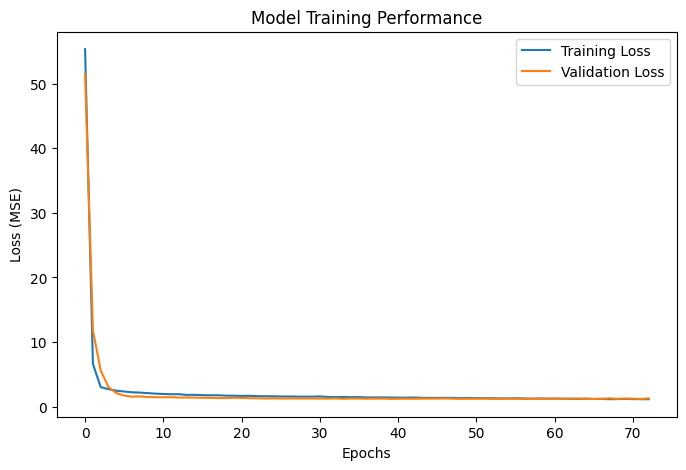

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(m5.history['loss'], label='Training Loss')
plt.plot(m5.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model Training Performance")
plt.legend()
plt.show()

## Model 6: Optuna XGBoost

In [ ]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Define objective function for Optuna
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 10, 25),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.005, 3.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 3.0, 15.0),
        "random_state": 42
    }

    model = XGBRegressor(objective="reg:squarederror", **params)

    # Use cross-validation to evaluate model
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1)
    return np.mean(scores)

# Create study and optimize
study = optuna.create_study(direction="maximize")  # We maximize negative MAE (minimizing MAE)
study.optimize(objective, n_trials=50, n_jobs=-1)

# Train final model with best parameters
best_params = study.best_params
model_optimized = XGBRegressor(objective="reg:squarederror", **best_params)
model_optimized.fit(X_train, y_train)

# Make predictions
y_pred_optuna = np.expm1(model_optimized.predict(X_val))  # Reverse log transformation

# Evaluate model
mae = mean_absolute_error(y_val, y_pred_optuna)
print("Best Parameters:", best_params)
print("MAE:", mae)


[I 2025-03-03 19:52:52,915] A new study created in memory with name: no-name-aaee017d-9904-479c-9102-77059702f1fc
/var/folders/_z/pk7xchh534z0b20y163z8lbc0000gn/T/ipykernel_57263/1069408239.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/_z/pk7xchh534z0b20y163z8lbc0000gn/T/ipykernel_57263/1069408239.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.005, 3.0),
/var/folders/_z/pk7xchh534z0b20y163z8lbc0000gn/T/ipykernel_57263/1069408239.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be re

Best Parameters: {'max_depth': 23, 'learning_rate': 0.02978460637988067, 'n_estimators': 511, 'subsample': 0.8277800124360013, 'reg_alpha': 0.007013352310423105, 'reg_lambda': 7.656404845762019}
MAE: 4540.635318670759


In [ ]:
# Compute Evaluation Metrics
mae = mean_absolute_error(y_val, y_pred_optuna)
mse = mean_squared_error(y_val, y_pred_optuna)
mape = mean_absolute_percentage_error(y_val, y_pred_optuna)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_optuna)

# Print Results
print(f"Model 4 (XGBoost) Performance:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MAPE  (Mean Absolute Percentage Error): {mape:.4f}")
print(f"MSE  (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Model 4 (XGBoost) Performance:
MAE  (Mean Absolute Error): 4540.6353
MAPE  (Mean Absolute Percentage Error): 14.2175
MSE  (Mean Squared Error): 82438376.6338
RMSE (Root Mean Squared Error): 9079.5582
R² Score: 0.7271


# Comparison

In [ ]:
# Ensure all models are trained and available
y_pred_baseline = np.expm1(np.clip(baseline.predict(X_val_scaled), -50, 50))  # Baseline Model
y_pred_baseline_mean = np.full_like(y_val, np.expm1(baseline_mean))
y_pred_model_1 = np.expm1(model_1.predict(X_val))  # Decision Tree
y_pred_model_2 = np.expm1(model_2.predict(X_val))  # Random Forest
y_pred_model_3 = np.expm1(model_3.predict(X_val))  # Gradient Boosting
y_pred_model_4 = np.expm1(model_4.predict(X_val))  # XGBoost
y_pred_model_5 = np.expm1(model5.predict(X_val_scaled))  # Neural Network
y_pred_optuna = np.expm1(model_optimized.predict(X_val))  # Optuna

61/61 [==============================] - 0s 2ms/step


In [ ]:
# Create a dictionary to store model results
results = {}

# Function to calculate metrics
def evaluate_model(name, y_true, y_pred):
    results[name] = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R² Score": r2_score(y_true, y_pred),
        "MAPE (%)": mean_absolute_percentage_error(y_true, y_pred) * 100  # Using sklearn's function

    }

# Evaluate all models
evaluate_model("Baseline (Linear Regression)", y_val, y_pred_baseline)
evaluate_model("Baseline (Mean)", y_val, y_pred_baseline_mean)
evaluate_model("Decision Tree", y_val, y_pred_model_1)
evaluate_model("Random Forest", y_val, y_pred_model_2)
evaluate_model("Gradient Boosting", y_val, y_pred_model_3)
evaluate_model("XGBoost", y_val, y_pred_model_4)
evaluate_model("Neural Network", y_val, y_pred_model_5)
evaluate_model("Optuna XGBoost", y_val,y_pred_optuna)

In [ ]:
# Create a df to showcase the results
results_df = pd.DataFrame(results).T

# Convert scientific notation to fixed-point format
results_df_formatted = results_df.copy()

# Format all float columns to remove scientific notation
results_df_formatted = results_df_formatted.applymap(lambda x: f"{x:,.2f}" if isinstance(x, float) else x)

results_df_formatted

,MAE,MSE,RMSE,R² Score,MAPE (%)
Baseline (Linear Regression),"9,446.91","252,634,934.95","15,894.49",0.16,"1,302.27"
Baseline (Mean),"12,381.10","380,881,926.85","19,516.20",-0.26,"1,499.22"
Decision Tree,"5,418.03","117,288,980.65","10,830.00",0.61,"1,874.61"
Random Forest,"7,222.93","186,006,650.40","13,638.43",0.38,"1,416.82"
Gradient Boosting,"6,920.49","166,494,226.24","12,903.26",0.45,"1,379.05"
XGBoost,"5,087.18","99,687,621.98","9,984.37",0.67,"1,283.89"
Neural Network,"6,387.61","129,758,337.12","11,391.15",0.57,"1,424.45"
Optuna XGBoost,"4,540.64","82,438,376.63","9,079.56",0.73,"1,421.75"


# Creating a pkl file

In [ ]:
best_params = study.best_params
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 23, 'learning_rate': 0.02978460637988067, 'n_estimators': 511, 'subsample': 0.8277800124360013, 'reg_alpha': 0.007013352310423105, 'reg_lambda': 7.656404845762019}


In [ ]:

# Train final model with best parameters
best_params = study.best_params
model_optimized = XGBRegressor(objective="reg:squarederror", **best_params)
model_optimized.fit(X_train, y_train)

# Save the trained model instead of just parameters
joblib.dump(model_optimized, "model.pkl")
print("Trained model saved to model.pkl")


NameError: name 'study' is not defined

In [ ]:
# Save the best parameters
with open("best_params.pkl", "wb") as f:
    pickle.dump(study.best_params, f)

print("Best parameters saved to best_params.pkl")


Best parameters saved to best_params.pkl


In [ ]:
import pickle
import joblib
from xgboost import XGBRegressor

# Step 1: Load the best hyperparameters from the pickle file
with open("best_params.pkl", "rb") as f:
    best_params = pickle.load(f)

# Step 2: Train the model using the loaded hyperparameters
model_optimized = XGBRegressor(objective="reg:squarederror", **best_params)

# Ensure X_train and y_train are available in your script
model_optimized.fit(X_train, y_train)

# Step 3: Save the trained model
joblib.dump(model_optimized, "model.pkl")
print("Trained model saved successfully to model.pkl")


Trained model saved successfully to model.pkl


In [ ]:
X_new.columns

Index(['prod_year', 'mileage', 'airbags', 'engine_volume',
       'leather_interior_yes', 'fuel_type_lpg', 'Model_Grouped_e 350',
       'color_silver', 'color_orange', 'wheel_right-hand drive',
       'gear_box_type_tiptronic', 'cylinders', 'fuel_type_hybrid',
       'fuel_type_diesel', 'Model_Grouped_sonata', 'color_black',
       'category_sedan', 'Model_Grouped_camry', 'drive_wheels_front',
       'color_white', 'Model_Grouped_others', 'gear_box_type_manual',
       'manufacturer_lexus', 'Model_Grouped_gx 460', 'fuel_type_petrol',
       'manufacturer_toyota', 'manufacturer_hyundai', 'Model_Grouped_ml 350',
       'turbo', 'category_hatchback', 'color_grey', 'category_jeep',
       'drive_wheels_rear', 'manufacturer_mercedes-benz', 'Model_Grouped_fit',
       'gear_box_type_variator', 'category_coupe', 'color_blue',
       'Model_Grouped_highlander', 'manufacturer_honda',
       'Model_Grouped_elantra', 'doors_04-may', 'color_green',
       'Model_Grouped_prius', 'manufacturer_mazd

In [ ]:
def preprocess_data(df, model_features):
    """
    Apply preprocessing steps to the input DataFrame.
    Ensure output matches the model's expected features.
    """
    df['turbo'] = df['engine_volume'].str.contains('Turbo', case=False, regex=False).astype(str)

    # Lowercase column names
    df.columns = df.columns.str.lower()

    # Convert Turbo from "Yes"/"No" to binary (1/0)
    df["turbo"] = df["turbo"].apply(lambda x: 1 if x.lower() == "yes" else 0)

    # Convert Engine volume to cubic cm
    df["engine_volume"] = df["engine_volume"] * 1000

    # Convert Cylinders to integer
    df["cylinders"] = df["cylinders"].astype(int)

    # One-hot encoding for categorical variables
    categorical_cols = df.select_dtypes(include=["object"]).columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Ensure the order of columns matches the model's expected features
    for col in model_features:
        if col not in df:
            df[col] = 0  # Add missing columns as zero (for unseen categories)

    df = df[model_features]  # Reorder to match model input

    return df

def transform_input_data(data, model_features):
    """
    Convert input dictionary to DataFrame and apply preprocessing.
    """
    df = pd.DataFrame([data])
    return preprocess_data(df, model_features)

In [ ]:
preprocess_data(df,df.columns.tolist())

,id,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags,turbo
0,45654403,13328,0,0,0,2010,0,0,0,0,0,6,0,0,0,0,0,12,0
1,44731507,16621,0,0,0,2011,0,0,0,0,0,6,0,0,0,0,0,8,0
2,45774419,8467,0,0,0,2006,0,0,0,0,0,4,0,0,0,0,0,2,0
3,45769185,3607,0,0,0,2011,0,0,0,0,0,4,0,0,0,0,0,0,0
4,45809263,11726,0,0,0,2014,0,0,0,0,0,4,0,0,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,0,0,0,1999,0,0,0,0,0,4,0,0,0,0,0,5,0
19233,45778856,15681,0,0,0,2011,0,0,0,0,0,4,0,0,0,0,0,8,0
19234,45804997,26108,0,0,0,2010,0,0,0,0,0,4,0,0,0,0,0,4,0
19235,45793526,5331,0,0,0,2007,0,0,0,0,0,4,0,0,0,0,0,4,0


In [ ]:
print(df.columns.tolist())


['id', 'price', 'levy', 'manufacturer', 'model', 'prod_year', 'category', 'leather_interior', 'fuel_type', 'engine_volume', 'mileage', 'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color', 'airbags']


In [42]:
import pickle
from xgboost import XGBRegressor

# Load Pickle Model
with open("model.pkl", "rb") as file:
    model = pickle.load(file)

# Save as UBJ (Compact Binary JSON)
model.save_model("model.ubj")

print("✅ Model successfully converted to UBJ format!")


✅ Model successfully converted to UBJ format!


In [41]:
# Save the model as a JSON file
model.save_model("model.json")
